In [5]:
!pip install scikeras

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc,recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
## For Grid Search
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
tf.__version__

'2.18.0'

In [8]:
df=pd.read_csv("/content/drive/MyDrive/Practice_session/BackOrders.csv")

In [9]:
df.head(3)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No


In [10]:
# Check data type of each attribute
df.dtypes

,0
sku,int64
national_inv,int64
lead_time,float64
in_transit_qty,int64
forecast_3_month,int64
forecast_6_month,int64
forecast_9_month,int64
sales_1_month,int64
sales_3_month,int64
sales_6_month,int64


#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.

In [11]:
for col in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    df[col] = df[col].astype('category')

In [12]:
#Display data type of each variable
df.dtypes

,0
sku,int64
national_inv,int64
lead_time,float64
in_transit_qty,int64
forecast_3_month,int64
forecast_6_month,int64
forecast_9_month,int64
sales_1_month,int64
sales_3_month,int64
sales_6_month,int64


In [13]:
#### Delete sku attribute
np.size(np.unique(df.sku, return_counts=True)[0])

61589

In [14]:
df.drop('sku', axis=1, inplace=True)

In [15]:
#### Missing value analysis and dropping the records with missing values
df.isnull().sum()

,0
national_inv,0
lead_time,3403
in_transit_qty,0
forecast_3_month,0
forecast_6_month,0
forecast_9_month,0
sales_1_month,0
sales_3_month,0
sales_6_month,0
sales_9_month,0


In [16]:
#Since the number of missing values is about 5%. For initial analysis we ignore all these records
data1 = df.dropna(axis=0)

#### For neural networks we require the data to be in numeric form

In [17]:
cat_attr= ['potential_issue', 'deck_risk', 'oe_constraint',
           'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']
num_attr=data1.columns.difference(cat_attr)
cat_attr.pop()

print(num_attr)

print("\n")
print(cat_attr)

Index(['forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'in_transit_qty', 'lead_time', 'local_bo_qty', 'min_bank',
       'national_inv', 'perf_12_month_avg', 'perf_6_month_avg',
       'pieces_past_due', 'sales_1_month', 'sales_3_month', 'sales_6_month',
       'sales_9_month'],
      dtype='object')


['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']


#### Data preprocessing for numeric and categorical using pipelines

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
numeric_transformer = Pipeline(steps=[
                                      ('scale',StandardScaler()) ])

categorical_transformer = Pipeline(steps=[
                                         ('ohe',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num',numeric_transformer,num_attr) ,
                                              ('cat',categorical_transformer,cat_attr)])

In [19]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scale', StandardScaler())]),
                                 Index(['forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'in_transit_qty', 'lead_time', 'local_bo_qty', 'min_bank',
       'national_inv', 'perf_12_month_avg', 'perf_6_month_avg',
       'pieces_past_due', 'sales_1_month', 'sales_3_month', 'sales_6_month',
       'sales_9_month'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['potential_issue', 'deck_risk',
                                  'oe_constraint', 'ppap_risk', 'stop_auto_buy',
                                  'rev_stop'])])

In [20]:
#Performing train test split on the data
X, y = data1.loc[1:,data1.columns!='went_on_backorder'], data1.loc[:,'went_on_backorder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [21]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

In [22]:
y_test=y_test.replace({'Yes':1,'No':0})
y_train=y_train.replace({'Yes':1,'No':0})

<ipython-input-22-26f2d260ecc8>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test=y_test.replace({'Yes':1,'No':0})
<ipython-input-22-26f2d260ecc8>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_test=y_test.replace({'Yes':1,'No':0})
<ipython-input-22-26f2d260ecc8>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [23]:
## Convert to numeric
y_train=y_train.values
y_test=y_test.values

In [24]:
y_train

[0, 1, 1, 0, 0, ..., 0, 0, 1, 1, 0]
Length: 40730
Categories (2, int64): [0, 1]

In [25]:
train=X_train
test=X_test

In [26]:
print(train.shape)

print(test.shape)

(40730, 27)
(17456, 27)


### Perceptron Model (MLP)

In [27]:
perceptron_model = Sequential()
perceptron_model.add(Dense(1, input_dim=27, activation='tanh'))
perceptron_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
perceptron_model.compile(loss='binary_crossentropy',
                         optimizer='sgd',
                         metrics=['accuracy'])

In [29]:
perceptron_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              28 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30 (120.00 B)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
perceptron_model_history = perceptron_model.fit(train,
                                                y_train,
                                                epochs=5,
                                                batch_size=32,
                                                validation_split=0.2)

Epoch 1/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8096 - loss: 0.5644 - val_accuracy: 0.8110 - val_loss: 0.4858
Epoch 2/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8148 - loss: 0.4800 - val_accuracy: 0.8110 - val_loss: 0.4850
Epoch 3/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8122 - loss: 0.4832 - val_accuracy: 0.8110 - val_loss: 0.4846
Epoch 4/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8115 - loss: 0.4842 - val_accuracy: 0.8110 - val_loss: 0.4843
Epoch 5/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8082 - loss: 0.4886 - val_accuracy: 0.8110 - val_loss: 0.4839


In [31]:
# lets write a function to get the metrics & loss plots

def plot(model_history, plot_type):
    val_type = "val_"+plot_type
    plt.plot(model_history.history[plot_type])
    plt.plot(model_history.history[val_type])
    plt.title('Accuracy Plot')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [32]:
perceptron_model

<Sequential name=sequential, built=True>

In [33]:
print(perceptron_model_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


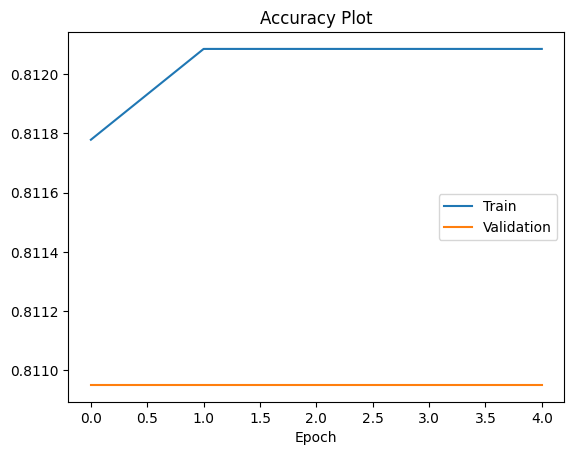

In [34]:
plot(perceptron_model_history, 'accuracy')

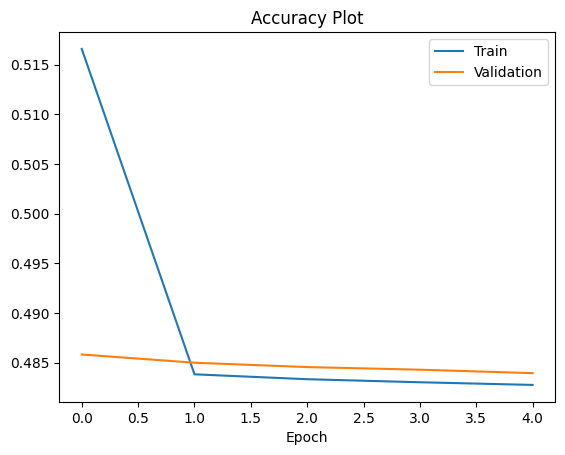

In [35]:
plot(perceptron_model_history, 'loss')

In [36]:
test_pred=(perceptron_model.predict(test) > 0.5).astype("int32")
train_pred=(perceptron_model.predict(train) > 0.5).astype("int32")

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [37]:
confusion_matrix(y_train, train_pred)

array([[33067,     0],
       [ 7663,     0]])

In [38]:
confusion_matrix(y_test, test_pred)

array([[14150,     0],
       [ 3306,     0]])

In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, test_pred,labels=[1,0]).reshape(-1)
(tn, fp, fn, tp)

(0, 3306, 0, 14150)

### Perceptron Model (MLP with 2 Neuron in Hidden Layer)

In [40]:
mlp_model = Sequential()
mlp_model.add(Dense(2, input_dim=27, activation='tanh'))
mlp_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
mlp_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
x=mlp_model.fit(train, y_train, epochs=5, batch_size=32,validation_split=0.2)

Epoch 1/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7945 - loss: 0.5067 - val_accuracy: 0.8113 - val_loss: 0.4804
Epoch 2/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8075 - loss: 0.4827 - val_accuracy: 0.8122 - val_loss: 0.4724
Epoch 3/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8150 - loss: 0.4682 - val_accuracy: 0.8128 - val_loss: 0.4694
Epoch 4/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8157 - loss: 0.4653 - val_accuracy: 0.8130 - val_loss: 0.4672
Epoch 5/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8177 - loss: 0.4607 - val_accuracy: 0.8137 - val_loss: 0.4652


In [42]:
print(pd.DataFrame(x.history))
print(x.history.keys())

   accuracy      loss  val_accuracy  val_loss
0  0.805579  0.493436      0.811318  0.480439
1  0.812638  0.474557      0.812178  0.472413
2  0.813344  0.470245      0.812792  0.469372
3  0.813988  0.467787      0.813037  0.467250
4  0.814295  0.465710      0.813651  0.465192
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [43]:
mlp_model

<Sequential name=sequential_1, built=True>

In [44]:
print(x.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


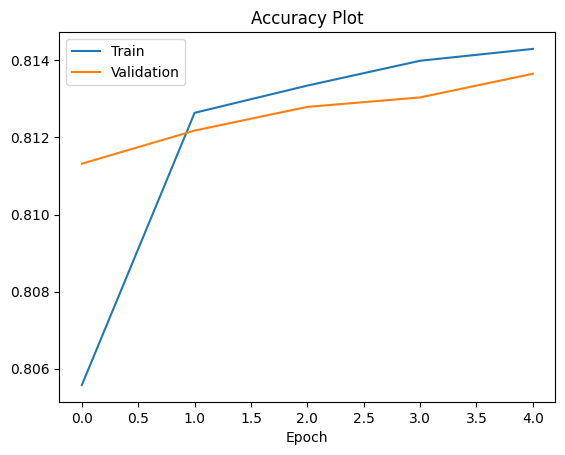

In [45]:
plot(x, 'accuracy')

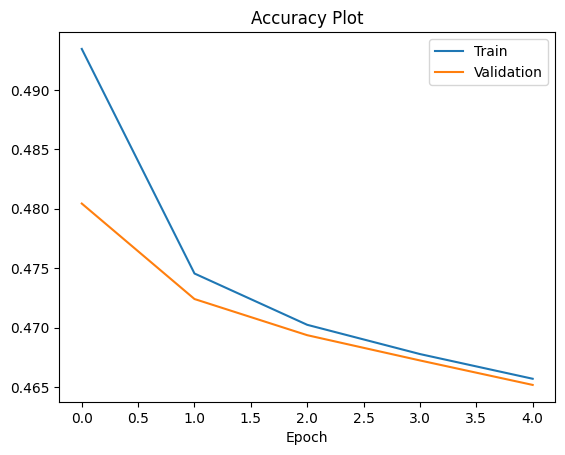

In [46]:
plot(x, 'loss')

#### Predictions

In [47]:
test_pred=(mlp_model.predict(test) > 0.5).astype("int32")
train_pred=(mlp_model.predict(train) > 0.5).astype("int32")

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [48]:
confusion_matrix(y_train, train_pred)

array([[32896,   171],
       [ 7399,   264]])

In [49]:
confusion_matrix(y_test, test_pred)

array([[14093,    57],
       [ 3224,    82]])

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, test_pred,labels=[1,0]).reshape(-1)
(tn, fp, fn, tp)

(82, 3224, 57, 14093)

### Perceptron Model (MLP with 1 Neuron in Hidden Layer)

In [51]:
mlp_model1 = Sequential()
mlp_model1.add(Dense(16, input_dim=27, activation='tanh'))
mlp_model1.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
mlp_model1.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
x=mlp_model1.fit(train, y_train, epochs=5, batch_size=32,validation_split=0.2)

Epoch 1/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8069 - loss: 0.4951 - val_accuracy: 0.8108 - val_loss: 0.4732
Epoch 2/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8122 - loss: 0.4721 - val_accuracy: 0.8112 - val_loss: 0.4700
Epoch 3/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8154 - loss: 0.4650 - val_accuracy: 0.8118 - val_loss: 0.4679
Epoch 4/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8120 - loss: 0.4675 - val_accuracy: 0.8121 - val_loss: 0.4662
Epoch 5/5
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8099 - loss: 0.4699 - val_accuracy: 0.8125 - val_loss: 0.4648


In [53]:
print(pd.DataFrame(x.history))
print(x.history.keys())

   accuracy      loss  val_accuracy  val_loss
0  0.811687  0.478512      0.810827  0.473221
1  0.811748  0.471055      0.811196  0.469966
2  0.811779  0.468683      0.811809  0.467874
3  0.812362  0.466861      0.812055  0.466201
4  0.812884  0.465334      0.812546  0.464845
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [54]:
mlp_model1

<Sequential name=sequential_2, built=True>

In [55]:
print(x.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


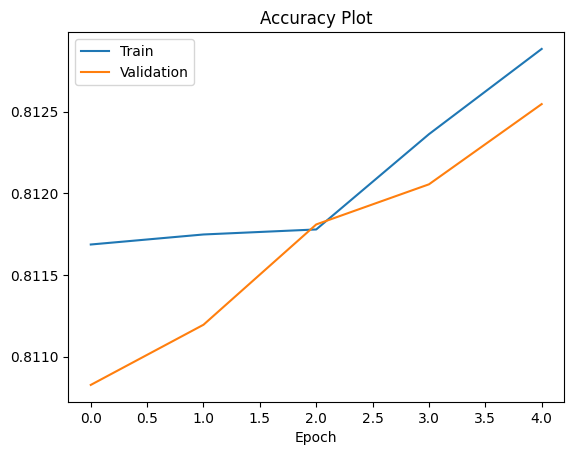

In [56]:
plot(x, 'accuracy')

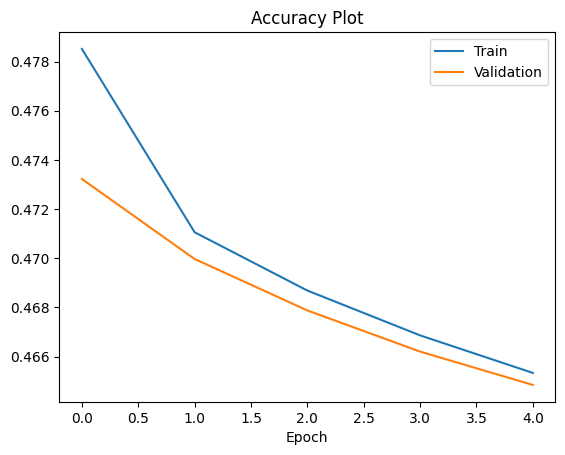

In [57]:
plot(x, 'loss')

#### Predictions

In [58]:
test_pred=(mlp_model1.predict(test) > 0.5).astype("int32")
train_pred=(mlp_model1.predict(train) > 0.5).astype("int32")

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [59]:
confusion_matrix(y_train, train_pred)

array([[32972,    95],
       [ 7521,   142]])

In [60]:
tn, fp, fn, tp = confusion_matrix(y_test, test_pred,labels=[1,0]).reshape(-1)
(tn, fp, fn, tp)

(45, 3261, 29, 14121)

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
